In [62]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D 
%matplotlib inline

In [63]:
# Dataset URL: https://raw.githubusercontent.com/beoutbreakprepared/nCoV2019/master/latest_data/latestdata.csv

In [64]:
train = pd.read_csv("covid2train.csv", index_col = 0)

In [81]:
def clean(train):
    features = ['age', 'sex', 'country', 'chronic_disease_binary', 'que_paso']
    xtrain = train[features]

# Dropping NA's from only 'sex' + 'country'    
    subset = xtrain.dropna(subset = ['age','sex','country'])
    countries = xtrain['country'].drop_duplicates().dropna()

# Replacing the age ranges with their means    
    mp = {'20-29': np.mean([20,29]), '40-49': np.mean([40,49]),'50-59': np.mean([50,59]),
          '60-69': np.mean([60,69]), '70-79': np.mean([70,79]),
          '80-89': np.mean([80,89]),'90-99': np.mean([90,99]), '80-': 80}
    
# Dictionary replacing countries with numerical values
    mp2 = {}
    key = np.arange(len(countries) + 1)
    for i,j in zip(countries,key):
        val = {i:j}
        mp2.update(val)
        
    mp3 = {'male': 0, 'female': 1}
        
# Updating the training data with new values
    subset = subset.replace(mp).replace(mp2).replace(mp3)
    subset['chronic_disease_binary'] = subset['chronic_disease_binary']*1
    subset['age'] = subset['age'].astype(float)
    
    xtrain = subset
    ytrain = subset['que_paso']
    return xtrain, ytrain, mp2

In [82]:
xtrain, ytrain, mp2 = clean(train)

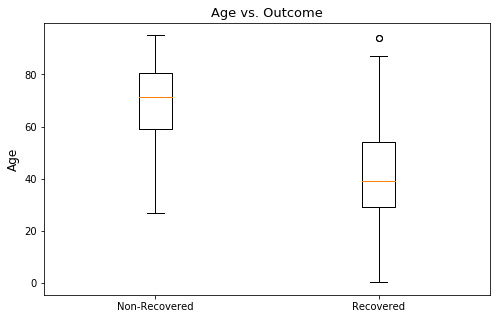

In [83]:
age_death = xtrain['que_paso'] == 0
age_rec = xtrain['que_paso'] == 1

xdeath = xtrain[age_death]
xrec = xtrain[age_rec]

age1 = xdeath['age']
age2 = xrec['age']

data = [age1, age2]
fig, ax = plt.subplots(figsize = (8,5))
ax.set_title('Age vs. Outcome', fontsize = 13)

ax.boxplot(data, labels = ['Non-Recovered', 'Recovered'])
ax.set_ylabel("Age", fontsize = 12)
plt.show()

In [84]:
xtrain2 = xtrain.drop('que_paso', axis = 1)

In [133]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB 

clfs = {"AdaBoost": AdaBoostClassifier(random_state = 42),
    "Naive Bayes": GaussianNB(),
    "Random Forest": RandomForestClassifier(n_estimators = 500,
                           n_jobs = -1, min_samples_leaf = 2,
                           bootstrap = True, random_state = 42),
    "Logistic Regression": LogisticRegression(solver = 'saga',
                                             random_state = 42)}
ML = list(clfs.values())
names = list(clfs.keys())

clf = ML[0].fit(xtrain2, ytrain)

var_imp = clf.feature_importances_
var = ['Age', 'Sex','Country', 'Chronic Disease']

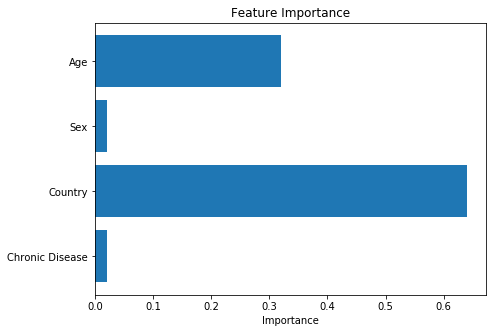

In [134]:
fig, ax = plt.subplots(figsize = (7,5))

y_pos = np.arange(len(var))

ax.barh(y_pos, var_imp, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(var)
ax.invert_yaxis() 
ax.set_xlabel('Importance', fontsize = 10)
ax.set_title('Feature Importance', fontsize = 12)

plt.show()

In [135]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, SVR
from sklearn.linear_model import LogisticRegression

In [136]:
def confusion_plot(clfs_dict, xtest, ytest):
    ML = list(clfs_dict.values())
    names = list(clfs_dict.keys())
    
    for i in ML:
        disp = plot_confusion_matrix(i, xtest, ytest,
                                     display_labels = ["Non-Recovered", "Recovered"],
                                     cmap = 'Blues',
                                     normalize = 'true')
        disp.ax_.set_title("Confusion Matrix: " + names[ML.index(i)])

In [150]:
def classifier(data, clfs_dict):
    selection = 0
    X = data.drop(["que_paso"], axis = 1)
    y = data.iloc[:,-1] 
    xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.5)
    scaler = StandardScaler()
    scaler.fit(xtrain)
    scaler.fit(xtest)
    xtrain = scaler.transform(xtrain)
    xtest = scaler.transform(xtest)
#     while selection != 4:
#         print("1. SVM")
#         print("2. Random Forest")
#         print("3. Logistic Regression")
#         print("4. Quit")
#         selection = int(input("Choose your ML method: "))
        
#         if selection == 4:
#             print("Goodbye!")
#             break
            
#         else:

    ML = list(clfs_dict.values())
    names = list(clfs_dict.keys())
    plt.figure(figsize = (7,5))
    
    for i in ML:
        clf = i.fit(xtrain,ytrain)
        yprob = clf.predict_proba(xtest)[::,1]
        ypred = clf.predict(xtest)
        fpr, tpr, thresholds = metrics.roc_curve(ytest, yprob)
        auc = round(metrics.auc(fpr,tpr),4)
        acc = round(accuracy_score(ytest, ypred),4)
        
        print("\nThe AUC for", names[ML.index(i)], "is", auc) 
        print("The accuracy score for", names[ML.index(i)], "is", acc)
        
        plt.plot(fpr, tpr, lw = 1, label = names[ML.index(i)]) # + '. AUC: '+ str(auc))
        plt.plot([0, 1], [0, 1], color = 'navy', lw = 1, linestyle = '--')
        plt.xlabel("False Positive Rate", fontsize = 11)
        plt.ylabel("True Positive Rate", fontsize = 11)
        plt.legend()
        plt.title("ROC Curve", fontsize = 13)
    return xtest, ytest


The AUC for AdaBoost is 0.9379
The accuracy score for AdaBoost is 0.8724

The AUC for Naive Bayes is 0.9104
The accuracy score for Naive Bayes is 0.8516

The AUC for Random Forest is 0.9475
The accuracy score for Random Forest is 0.8843

The AUC for Logistic Regression is 0.9174
The accuracy score for Logistic Regression is 0.8635


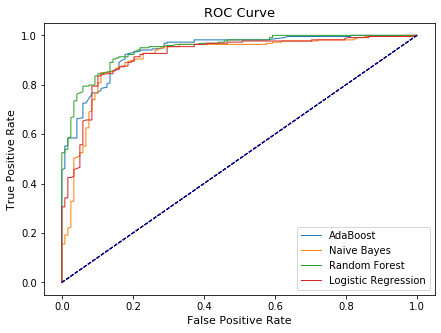

In [163]:
xtest, ytest = classifier(xtrain, clfs)

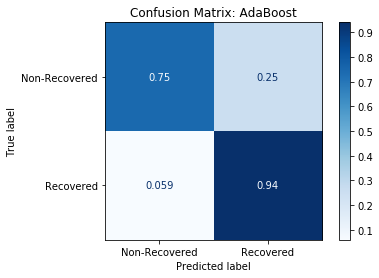

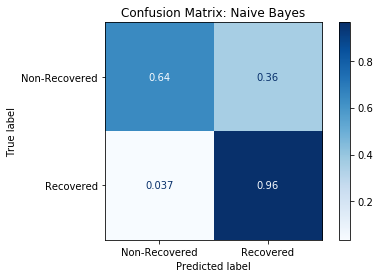

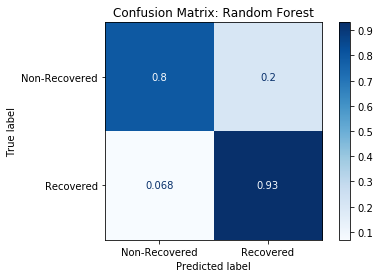

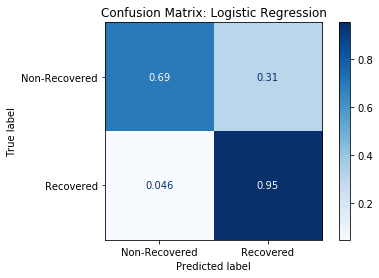

In [164]:
confusion_plot(clfs, xtest, ytest)

In [79]:
def project(xtrain):
    zero = xtrain['que_paso'] == 0
    one = xtrain['que_paso'] == 1
    x0 = xtrain[zero]
    x1 = xtrain[one]
    
    age0 = x0.iloc[:, 0] 
    sex0 = x0.iloc[:, 1] 
    country0 = x0.iloc[:,2]
    chronic0 = x0.iloc[:,3]
    
    age1 = x1.iloc[:,0]
    sex1 = x1.iloc[:,1]
    country1 = x1.iloc[:,2]
    chronic1 = x1.iloc[:,3]
    
    # Visualizing data in higher dimension 
    fig = plt.figure(figsize = (8,6)) 
    ax = fig.add_subplot(111, projection = '3d') 
    ax.scatter(sex0, chronic0, age0, label = 'Non-Recovered')
    ax.scatter(sex1, chronic1, age1, label = 'Recovered')
    ax.set_xlabel("Sex")
    ax.set_ylabel("Chronic Disease (Y/N)")
    ax.set_zlabel("Age")
    plt.legend()
    plt.show()

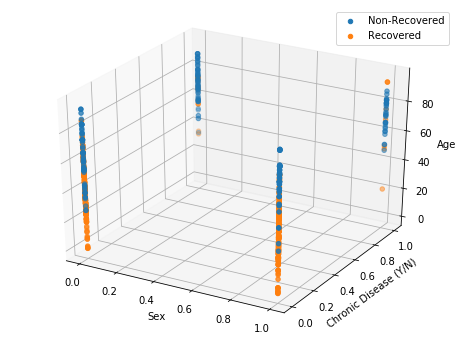

In [80]:
project(xtrain)